# Домашнее задание 1

Это домашнее задание по материалам первого семинаров. Дедлайн по отправке - 23:55 10 февраля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_1

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим следуюущую задачу оптимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} \left[f(x) := \tfrac{1}{2} x^T A x - b^T x\right],
\end{equation}
где $A \in \mathbb{R}^{d \times d}$, $b \in \mathbb{R}^d$.

__(а)__ Является ли данная задача всегда выпуклой/сильной выпуклой? При каких условиях?

#Ответ
Нет, она не всегда является выпуклой/сильно выпуклой.

Данная задача является выпуклой тогда и только тогда, когда матрица А  положительная полуопределенная.

Является сильно выпуклой, тогда и только тогда, когда матрица А строго положительно определенная.

Но, она может и не являться сильно выпуклой, если матрица А, например, нулевая, и может не являться выпуклой, когда матрица А отрицательная.


__(б)__ Оцените для этой функции константу сильной выпуклости и константу Липшица градиента.

#Ответ
Константа сильной выпуклой равна, наименьшему собственному числу матрицы А, при выполнении выше описанных условий.

Найдем дифференциал функции f(x):

$$
df(x) = \frac{1}{2} ⟨Ax, dx⟩ + \frac{1}{2}\langle Adx, x \rangle - \langle b, dx ⟩ = ⟨\frac{1}{2}(A + A^T)x - b, dx ⟩
$$

$f'(x) = Ax - b$


$$
Hf(x) = \frac{1}{2} (A + A^T)
$$

Теперь мы можем оценить константу сильной выпуклости, как
$$
\mu = \frac{1}{2} \lambda_{min}(A + A^T)
$$


Посчитаем константу Липшица для производной функции f(x):
$$
||f'(y) - f'(x)|| = ||Ay - b - Ax + b|| \le ||A|| \cdot ||y-x||
$$
Следовательно, $L = ||A||$. Если норма это 2-я норма, то $L = ||A||_2 = \lambda_{max}(A)$


## Задача 2

Продолжаем работать с задачей оптимизации из предыдущей задачи.

# А)

Придумайте (или найдите) способ генерации матрицы $А$, так чтобы $f$ была сильно выпуклой, а также можно было задавать и менять $d, \mu, L$.

In [1]:
#@title Импорт библиотек
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

import jax
from jax import numpy as jnp
from jax import grad

In [2]:
#@title Генерация матрицы
#ответ
def generate_matrix(d, mu, L):
    """
    Функция генерации симметричной квадратной матрицы(d, d),
    с минимальным собственным числом mu, и нормой матрицы L.

    Inputs:
    - d     : размер матрицы 
    - mu    : минимальное собственное число в матрице
    - L     : норма матрицы    
    
    Returns:
    Сгенерированную матрицу.
    """
    tmp = np.random.rand(d, d)  # генерим случайную матрицу
    tmp = tmp + tmp.T           # делаем её симметричной
    u, s, vh = la.svd(tmp)      # раскладываем по svd
    
    s = s - np.amin(s) + mu     # вычитаем минимальный элемент и прибавляем желаемое значение mu
    s[:-1] = s[:-1] * np.sqrt(L * L - mu * mu) / la.norm(s[:-1]) 
    # делим на норму элементов кроме mu, и умножаем на корень из mu, чтобы в итоге норма получилась равна L

    D = np.diag(s)
    A = u.T @ D @ u

    return A

In [3]:
generate_matrix

<function __main__.generate_matrix(d, mu, L)>

# Б)

Реализуйте метод градиетного спуска:
\begin{equation}
x_{k+1} = x_k - \gamma_k \nabla f(x_k),
\end{equation}
для квадратичной функции с матрицей, которую сгенерировали выше и произвольным вектором $b$ (лучше ненулевым). Желательно, уже сейчас и метод, и подсчет градиента реализовывать, как отдельные функции, при этом чтобы метод принимал саму целевую функцию (или ее градиент), как параметр. В дальнейшем будет легче менять целевую функцию в задаче минимизации и тестировать разные методы. 

In [4]:
#@title Отрисовка графиков
def draw_4_image(X):
    """
    Функция отрисовки 4-х картинок. 
    Получает массив из абсолютных ошибок, и рисует в осях:
    1. x    - y
    2. x    - logy
    3. logx - y
    4. logx - logy
    (x - номер итерации, y - error)
    
    Inputs:
    - X: массив абсолютных ошибок, между точным решением и решением,
    полученным с помощью метода градиентного спуска.
    
    Returns:
    None.
    """

    x = np.linspace(1, len(X), len(X))
    fig, ax = plt.subplots(2, 2, figsize=(16,12))
    ax = ax.ravel()

    #1
    y = X
    ax[0].set_title("Ошибка от номера итерации")
    ax[0].plot(x, y) 
    ax[0].set_xlabel("Номер итерации")
    ax[0].set_ylabel("Ошибка")

    #2
    y = np.log(X)
    ax[1].set_title("Логарифм ошибки от номера итерации")
    ax[1].plot(x, y)
    ax[1].set_xlabel("Номер итерации")
    ax[1].set_ylabel("Логарифм ошибки")
    legend_box = ax[1].legend(framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")

    #3
    y = X
    ax[2].set_title("Ошибка от логарифма номера итерации")
    ax[2].plot(np.log(x), y)
    ax[2].set_xlabel("Логарифм номера итерации")
    ax[2].set_ylabel("Ошибка")

    #4
    y = np.log(X)
    ax[3].set_title("Логарифм ошибки от логарифма номера итерации")
    ax[3].plot(np.log(x), y)
    ax[3].set_xlabel("Логарифм номера итерации")
    ax[3].set_ylabel("Логарифм ошибки")

    fig.show()

def draw_log_error_iter_theory(X, mu, L, x0, x_acc):
    """
    Функция отрисовки картинки и двух теоретических ошибок.
    Получает массив из абсолютных ошибок, параметры генерации матрицы (mu, L),
    начальное приближение и "точное решение". Рисует на одном графике 
    теоретические ошибки и практические, в осях (номер итерации - log(error))

    Inputs:
    - X     : массив абсолютных ошибок, между точным решением и решением,
    полученным с помощью метода градиентного спуска.
    - mu    : минимальное собственное число при генерации матрицы.
    - L     : норма матрицы
    - x0    : начальное приближение
    - x_acc : точное решение
    
    Returns:
    None.
    """
    x = np.linspace(1, len(X), len(X))
    fig, ax = plt.subplots(figsize=(12,9))

    y = np.log(X)
    ax.set_title("Логарифм ошибки от номера итерации")
    ax.plot(x, y, label='Практика')

    # Ошибка для первой оценки с семинара 
    y = x * np.log(1-mu**2/(4 * L**2)) + np.log(la.norm(x0 - x_acc))
    ax.plot(x, y, '--', label='Теория 1')

    # Ошибка для второй оценки с семинара
    y = x * np.log(1-mu/ L) + np.log(la.norm(x0 - x_acc))
    ax.plot(x, y, '--', label='Теория 2')


    ax.set_xlabel("Номер итерации")
    ax.set_ylabel("Логарифм ошибки")
    legend_box = ax.legend(framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    fig.show()

def draw_log_error_iter(X):
    """
    Функция отрисовки картинки.
    Получает массив из абсолютных ошибок. Рисует на графике ошибки 
    в осях (номер итерации - log(error))

    Inputs:
    - X : массив абсолютных ошибок, между точным решением и решением,
    полученным с помощью метода градиентного спуска.
    
    Returns:
    None.
    """
    x = np.linspace(1, len(X), len(X))
    fig, ax = plt.subplots(figsize=(12,9))

    y = np.log(X)
    ax.set_title("Логарифм ошибки от номера итерации")
    ax.plot(x, y, label='Практика')

    ax.set_xlabel("Номер итерации")
    ax.set_ylabel("Логарифм ошибки")
    fig.show()


In [5]:
#@title Градиентный спуск
def gradient_descent(
        f, grad_f, x0, 
        lr, iter, error_criterion):
    """
    Это градиентный спуск.
    Он получает на вход целевую функцию, функцию градиента целевой функции, 
    начальную точку, функцию learning rate, количество итераций и 
    функцию подсчета ошибки. И применяетметод градиентного спуска.

    Inputs:
    - f                 : целевая функция, минимум которой мы хотим найти.
    - grad_f            : функция градиента целевой функции.
    - x0                : начальная точка.
    - lr                : функция learning rate.
    - iter              : количество итераций.
    - error_criterion   : функция подсчета ошибки

    Returns:
    Наилучшую минимальную точку, которую удалось найти.
    """
    
    x = x0
    eps = 10e-8
    for k in range(iter):
        cur = x
        x = x - lr(k, x, 0, f, grad_f) * grad_f(x)

        error = error_criterion(cur, x, f)
        if (error < eps):
            return x

    return x   

def gradient_descent_values(
        f, grad_f, x0, 
        lr, iter, error_criterion, 
        eps, x_acc):
    """
    Это градиентный спуск.
    Он получает на вход целевую функцию, функцию градиента целевой функции, 
    начальную точку, функцию learning rate, количество итераций и 
    функцию подсчета ошибки, точность с которой считать, точное решение, которое
    мы откуда-то знаем.
    И применяетметод градиентного спуска.

    Inputs:
    - f                 : целевая функция, минимум которой мы хотим найти.
    - grad_f            : функция градиента целевой функции.
    - x0                : начальная точка.
    - lr                : функция learning rate.
    - iter              : количество итераций.
    - error_criterion   : функция подсчета ошибки

    Returns:
    Наилучшую минимальную точку, которую удалось найти.
    """
    
    x = x0
    X = []
    
    for k in range(iter):
        cur = x
        x = x - lr(k, x, x_acc,
                   f, grad_f) * grad_f(x)
        error = error_criterion(cur, x, 
                                x_acc, f)

        X.append(error)
        if (error < eps):
            return X
        
    return np.array(X)

# В)

Для задачи с $d = 10$, $\mu = 1$ и $L = 100$ найдите точное решение $x^*$, например, с помощью пакетов линейной алгебры (есть встроенный в numpy). Запустите градиентный спуск на $10^4$ итераций с шагом $\gamma_k = \tfrac{1}{L}$ и произвольной начальной точкой $x_0$ (если $b$ ненулевой, то можно взять нулевой $x_0$). Проверьте сходится ли он. В качестве критериев сходимости используйте $\| x_k - x^*\|^2$.

In [6]:
d, mu, L, iter = 10, 1, 100, 10000
iter = 10000
b = np.random.rand(d)
A = generate_matrix(d, mu, L)
x0 = np.random.rand(d)
eps = 10e-7

x_acc = np.linalg.solve(A, b)

In [7]:
# Функция из задания
func_f1 = lambda x: 0.5*x.T@A@x - b.T @ X
# Градиент функции
grad_func_f1 = lambda x: A@x.T - b

# Autograde solution, но работает очень долго
#grad_func_f1 = lambda x: grad(func_f1)(x)

# Критерий ошибки (самый стандартный)
error_criterion_standard = lambda x_cur, x_next, x_acc, f: la.norm(x_cur - x_acc)

# Критерий ошибки (самый стандартный)
error_criterion_st = lambda x_cur, x_next, f: la.norm(x_cur - x_acc)

# Стандартный параметр learning rate в градиентном спуске
lr_standard = lambda k, x, x_acc, f, grad_f: 1/L

x_my = gradient_descent(func_f1, grad_func_f1, x0, 
                        lr_standard, iter, error_criterion_st)

print("Numpy solution: ", x_acc)
print("My answer: ", x_my)
print("Difference: ", la.norm(x_acc - x_my))

Numpy solution:  [ 0.27631885  0.26595371  0.04376373  0.08088918  0.18083965  0.10236458
 -0.01679322  0.22099353  0.36385723 -0.21720639]
My answer:  [ 0.27631881  0.26595367  0.04376373  0.08088918  0.18083962  0.10236457
 -0.01679321  0.22099351  0.36385718 -0.21720635]
Difference:  9.879259104034527e-08


## Вывод:
Да, метод градиентного спуска сходится по критерию нормы между "точным" решением и решением градиентного спуска.

# Г)
Постройте график сходимости: по оси $x$ отложите номер итерации, по $y$ значения критерия на этой итерации. Поиграйтесь с осями, например, поставьте по $y$ логарифмический масштаб. Не забудьте подписать оси. Сделайте вывод о характере сходимости.

In [8]:
# Подсчет ошибки для градиента
X = gradient_descent_values(func_f1, grad_func_f1, x0, 
                            lr_standard, iter, error_criterion_standard, 
                            eps, x_acc)

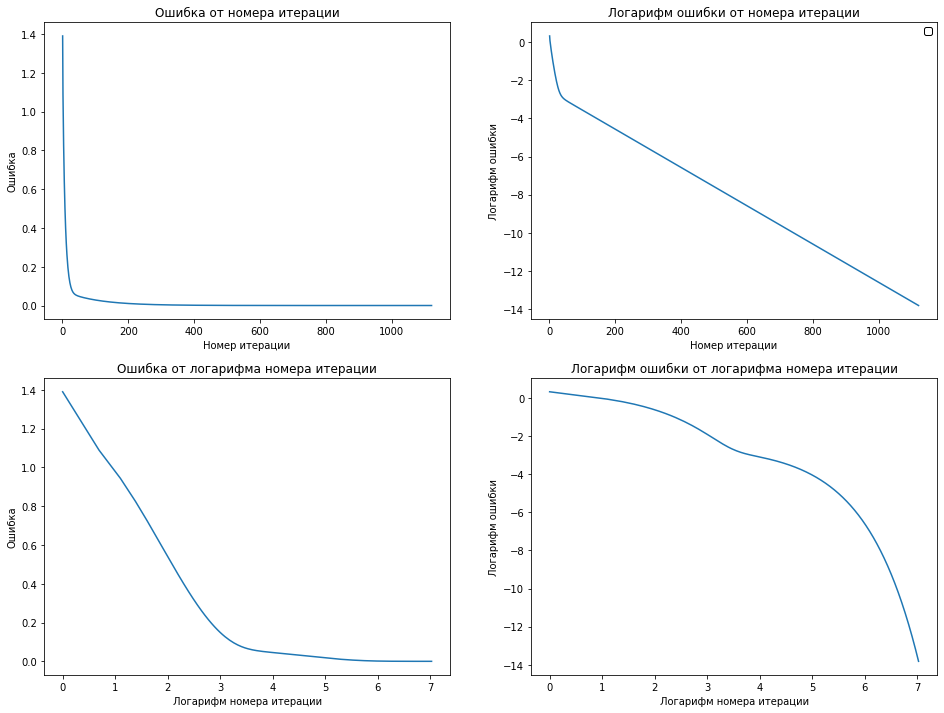

In [9]:
draw_4_image(X)

## Вывод
Последние два графика не имеют почти никакой информативности, а на первом очень неудобный масштаб, поэтому сейчас и в дальнейшем будем смотреть только на графики с осями $(iter, log(error))$, остальные не слишком информативны. 

Характер сходимости линейный.

# Д)
Добавьте на график теоретическую сходимость, полученную на семинаре. Добавьте легенду, чтобы можно было отличить, какой график за что отвечает. Сделайте вывод.

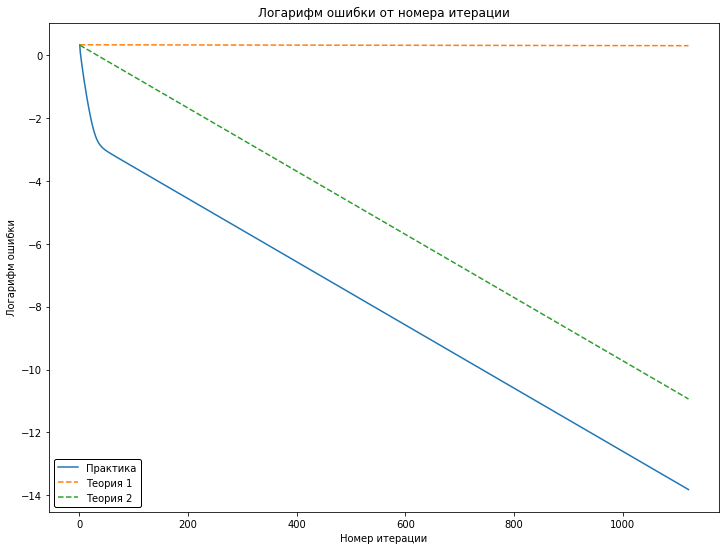

In [10]:
draw_log_error_iter_theory(X, mu, L, x0, x_acc)

## Вывод: 
Первая теоретическая оценка грубая, и на практике сходится быстрее, по крайне мере, на этой такой целевой функции. вторая же теоретическая идет параллельна нашей параллельна практическуму результату. Если же продолжить количество итераций, то теоретическая оценка продолжит уменьшаться, а на практике ошибка выйдет на плато, т.к. дальше будет уже расти ошибка округления, и общая ошибка выйдет на плато.

# Е)
Попробуйте метод с разными шагами (но постоянными в одном запуске) $\gamma_k = \gamma$. Уменьшайте и увеличивайте шаг. Нанесите все новые запуски на график (теоретическую сходимость можно убрать). 

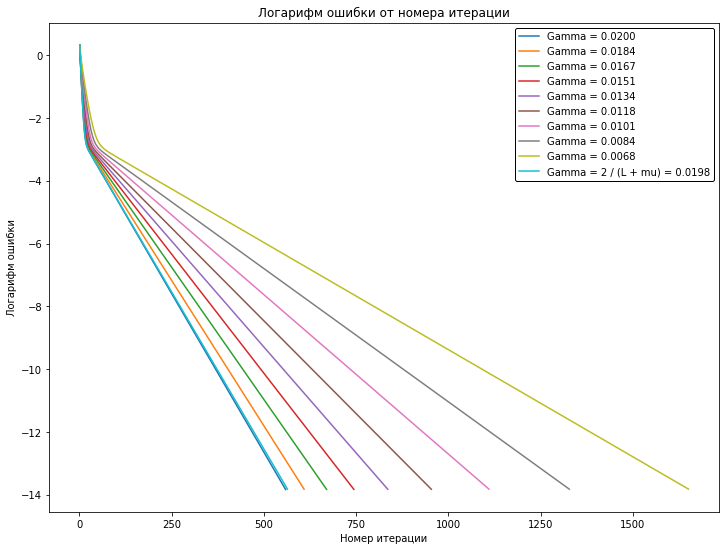

In [11]:
fig, ax = plt.subplots(figsize=(12,9))

ax.set_title("Логарифм ошибки от номера итерации")

# Параметры для перебора лямбды
start   = 2 / L
stop    = 0.02 / L
num     = 13

gamma = np.linspace(start=start,stop=stop, num=num)

# Критерий ошибки (самый стандартный)
error_criterion_standard = lambda x_cur, x_next, x_acc, f: la.norm(x_cur - x_acc)

for i in np.arange(9):  
    # Стандартный параметр learning rate в градиентном спуске
    lr_gamma = lambda k, x, x_acc, f, grad_f: gamma[i]

    y = gradient_descent_values(func_f1, grad_func_f1, 
                                x0, lr_gamma, iter, 
                                error_criterion_standard, eps, x_acc)

    # Рисуем
    y = np.log(y)
    x = np.linspace(1, len(y), len(y))
    ax.plot(x, y, label='Gamma = %.4f' % gamma[i])


# lr = 2 / (L + mu)
lr_gamma = lambda k, x, x_acc, f, grad_f: 2/(L + mu)

y = gradient_descent_values(func_f1, grad_func_f1, 
                                x0, lr_gamma, iter, 
                                error_criterion_standard, eps, x_acc)
# Рисуем
y = np.log(y)
x = np.linspace(1, len(y), len(y))
ax.plot(x, y, label='Gamma = 2 / (L + mu) = %.4f' % (2/(L + mu)))



ax.set_xlabel("Номер итерации")
ax.set_ylabel("Логарифм ошибки")

legend_box = ax.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")

## Вывод:
Чем больше гамма, тем быстрее сходится, но гамма не может быть больше, чем $\frac{2}{L}$.

# Ж)
Для задачи с $\mu = 0$ и $L = 1000$, проделайте те же действия, что и в пунктах (в), (г) с числом итераций равным $10^5$. Сделайте вывод.

In [ ]:
ar_mu = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
d, L, iter = 10,  1000, int(10e5)

# Стандартный параметр learning rate в градиентном спуске
lr_standard = lambda k, x, x_acc, f, grad_f: 1/L

# Критерий ошибки (самый стандартный)
error_criterion_standard = lambda x_cur, x_next, x_acc, f: la.norm(x_cur - x_acc)

# Критерий ошибки (самый стандартный)
error_criterion_st = lambda x_cur, x_next, f: la.norm(x_cur - x_acc)
fig, ax = plt.subplots(figsize=(12,9))

for mu in ar_mu:
    b = np.random.rand(d)
    A = generate_matrix(d, mu, L)
    x0 = np.random.rand(d)

    # Функция из задания
    func_f2 = lambda x: 0.5*x.T@A@x - b.T @ X
    # Градиент функции
    grad_func_f2 = lambda x: A@x.T - b

    x_acc = np.linalg.solve(A, b)

    x_my = gradient_descent(func_f2, grad_func_f2, x0, lr_standard, iter, error_criterion_st)
    print("Mu = ", mu, "Difference: ", la.norm(x_acc - x_my))

    # Подсчет ошибки для градиента
    X = gradient_descent_values(func_f1, grad_func_f1, x0, 
                            lr_standard, iter, error_criterion_standard, 
                            eps, x_acc)
    
    #ответ
    x = np.linspace(1, len(X), len(X))
    

    y = np.log(X)
    ax.set_title("Логарифм ошибки от номера итерации")
    ax.plot(x, y, label='mu = ' + str(mu))


ax.set_xlabel("Номер итерации")
ax.set_ylabel("Логарифм ошибки")
legend_box = ax.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
fig.show()

Mu =  1 Difference:  9.981895458923343e-08
Mu =  0.1 Difference:  9.998378595464073e-08


1. Работает очень долго (если использовать метод append из numpy, т.к. идет полное копирование, но это было в старой версии).

2. При уменьшении минимального собственного числа, решение с помощью пакетного решения (linalg.solve), выдает худший результат по сравнению с решением с помощью метода градиентного спуска, т.к. у нас одно из собственных чисел, почти ноль, а другое 1000, это плохо обусловленная матрица. Число обусловленности равно $10^8$, а это очень и очень много, т.к. $10^3$ уже считается плохо обусловленной. 

3. Если взять все компоненты вектора, кроме этого равным нулю, и взять большую компоненту у соответствующей минимальному собственному числу, то мы можем уйти в бесконечность (подразумевается, что минимальное собственное число равно нулю, поэтому в теории значение целевой функции будет минус бесконечность). 

## Вывод:
С уменьшением числа $\mu$ растет разница между пакетным решением с помощью numpy и решением с помощью градиентного спуска. Можно сделать вывод, что при плохо обусловленных матрицах лучше использовать градиентный спуск, а не linalg.solve.

# З) 
Все ли получилось в предыдущем пункте? Если нет, то поясните почему (если это еще не сделано в выводах прошлого пункта). Проделайте пункты (в)-(e), но с критерием сходимости $f(x_k) - f(x^*)$ и/или $f(\bar x_k) - f(x^*)$ (здесь $\bar x_k$ - средняя точка на текущей и предыдущих итерациях). Сделайте вывод.

In [ ]:
d, mu, L, iter = 10, 1, 100, 4000
iter = 10000
b = np.random.rand(d)
A = generate_matrix(d, mu, L)
x0 = np.random.rand(d)
eps = 10e-7

x_acc = np.linalg.solve(A, b)

In [ ]:
# Функция из задания
func_f1 = lambda x: 0.5*x.T@A@x - b.T @ x
# Градиент функции
grad_func_f1 = lambda x: A@x.T - b

# Autograde solution, но работает очень долго
#grad_func_f1 = lambda x: grad(func_f1)(x)

# Критерий ошибки (самый стандартный)
error_criterion_standard = lambda x_cur, x_next, x_acc, f: la.norm(x_cur - x_acc)

# Критерий ошибки (самый стандартный) для значения
error_criterion_st = lambda x_cur, x_next, f: la.norm(x_cur - x_acc)

# Критерий ошибки нормы разницы между функции от точного решения и текущего решения
error_criterion_func_acc = lambda x_cur, x_next, x_acc, f: la.norm(f(x_cur) - f(x_acc))

# Критерий ошибки нормы разницы функции от точного решения и от усредненного решения
error_criterion_func_mean = lambda x_cur, x_next, x_acc, f: la.norm(f(x_acc) - f((x_cur + x_next) / 2.0))


# Стандартный параметр learning rate в градиентном спуске
lr_standard = lambda k, x, x_acc, f, grad_f: 1/L

x_my = gradient_descent(func_f1, grad_func_f1, x0, 
                        lr_standard, iter, error_criterion_st)

print("Numpy solution: ", x_acc)
print("My answer: ", x_my)
print("Difference: ", la.norm(x_acc - x_my))

In [ ]:
error_func = [error_criterion_standard, error_criterion_func_acc, error_criterion_func_mean]
errror_func_name = ["||x - x^*||", "||f(x) - f(x^*)||", "||f(x_{mean}) - f(x^*)||"]
for k_error_func, k_error_func_name in zip(error_func, errror_func_name):
    fig, ax = plt.subplots(figsize=(12,9))

    ax.set_title("Логарифм ошибки от номера итерации $ \log" + k_error_func_name + "$")

    # Параметры для перебора лямбды
    start   = 2 / L
    stop    = 0.2 / L
    num     = 9

    gamma = np.linspace(start=start,stop=stop, num=num)

    for i in np.arange(9):  
        # Стандартный параметр learning rate в градиентном спуске
        lr_gamma = lambda k, x, x_acc, f, grad_f: gamma[i]

        y = gradient_descent_values(func_f1, grad_func_f1, 
                                x0, lr_gamma, iter, 
                                k_error_func, eps, x_acc)

        # Рисуем
        y = np.log(y)
        x = np.linspace(1, len(y), len(y))
        ax.plot(x, y, label='Gamma = ' + str(gamma[i]))


    ax.set_xlabel("Номер итерации")
    ax.set_ylabel("Логарифм ошибки")
    legend_box = ax.legend(framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    fig.show()

 ## Вывод
 Видно, что критерий $||x_k - x^* ||$ хуже, чем критерий $||f(x_k) - f(x^*)||$, а $||f(\bar x_k) - f(x^*)||$, т.к. наклон сходимости больше.
 Но при очень маленьких гаммах все равно не сойдется ни о одному из критериев, но по 2-му и 3-му критерию требуется меньшее количество итераций, чтобы сойтись к заданной точности. Также приходим к выводу, что чем больше $\lambda$, тем быстрее сходимость, но не больше, чем $\frac{2}{L}$.

# Бонусные пункты

Исследуйте другие техники подбора шага, озвученные на семинаре: 

1) Уменьшающийся с номером итерации шаг,

2) Наискорейший спуск: $\gamma_k = \arg\min_{\gamma} f(x_k - \gamma \nabla f(x_k))$,

3) Правила Армихо, Вульфа и Гольдстейна: смотри параграф 3.1 из https://www.csie.ntu.edu.tw/~r97002/temp/num_optimization.pdf,

4) Шаг Поляка-Шора: $\gamma_k = \tfrac{f(x^k) - f(x^*)}{\alpha \|\nabla f(x^k)\|^2}$, где $\alpha \geq 1$.

Эксперименты нужно провести, как для сильно выпуклых, так и выпуклых задач. Сравните не только число итераций, но и время работы методов. Учтите, что правила Армихо, Вульфа, Гольстейна и Поляка-Шора требуют подбора дополнительных параметров эврестически (поиграйте с этими параметрами отдельно и выберете какой подходит лучше).

In [ ]:
#@title Бонусные проекты
d, mu, L, iter = 10, 1, 100, 10000
iter = 10000
b = np.random.rand(d)
A = generate_matrix(d, mu, L)
x0 = np.random.rand(d)
eps = 10e-7

x_acc = np.linalg.solve(A, b)

# Функция из задания
func_f = lambda x: 0.5*x.T@A@x - b.T @ x
# Градиент функции
grad_func_f = lambda x: A@x.T - b

# Критерий ошибки (самый стандартный)
error_criterion_standard = lambda x_cur, x_next, x_acc, f: la.norm(x_cur - x_acc)

In [ ]:
#@title Уменьшающийся шаг с номером итерации шаг,

# Критерий ошибки (самый стандартный)
error_criterion_standard = lambda x_cur, x_next, x_acc, f: la.norm(x_cur - x_acc)
lr_1 = lambda k, x, x_acc, f, grad_f: 2/L / np.sqrt(k + 1)
lr_2 = lambda k, x, x_acc, f, grad_f: 2/L * np.sqrt(k/(k+L))
lr_3 = lambda k, x, x_acc, f, grad_f: 2/L 
lr_4 = lambda k, x, x_acc, f, grad_f: 2/L / (k+1)**0.2
lr_5 = lambda k, x, x_acc, f, grad_f: 2/L / (k+1)**(mu/L)
lr_6 = lambda k, x, x_acc, f, grad_f: 2/L / np.log(k+2)
lr_7 = lambda k, x, x_acc, f, grad_f: 2/(L+mu)

lr_functions = [lr_1, lr_2, lr_3, lr_4, lr_5, lr_6, lr_7]
lr_functions_name = ['$2/L * 1/ \sqrt{k+1}$', '$\sqrt{k}*2/L * 1/ \sqrt{k+L}$', '2/L', '2/L * 2/(k+1)^{0.01}', '2/L * 2/(k+1)^{mu/L}', '2/L * 1/log(k+2)', '2/(L+mu)']


fig, ax = plt.subplots(figsize=(12,9))
ax.set_title("Логарифм ошибки от номера итерации")


for lr_func_k, lr_func_name_k in zip(lr_functions, lr_functions_name): 
    y = gradient_descent_values(func_f1, grad_func_f1, 
                                x0, lr_func_k, iter, 
                                error_criterion_standard, eps, x_acc)

    # Рисуем
    y = np.log(y)
    x = np.linspace(1, len(y), len(y))
    ax.plot(x, y, label=lr_func_name_k)


ax.set_xlabel("Номер итерации")
ax.set_ylabel("Логарифм ошибки")
legend_box = ax.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
fig.show()

## Вывод:
Изменение константы шага градиентного спуска в зависимости от шага не дает никакого прироста по сравнению с постоянным шагом в $\frac{1}{L}$.

## Наискорейший спуск

Найдем минимальный аргумент для функции $f(x) = \frac{1}{2} x^TAx - b^Tx$

$\gamma_k = \arg\min_{\gamma} f(x_k - \gamma \nabla f(x_k))$,

$$
f(x_k - \gamma \nabla f(x_k)) = \frac{1}{2} (x_k - \gamma \nabla f(x_k))^TA(x_k - \gamma \nabla f(x_k)) - b^T(x_k - \gamma \nabla f(x_k)) = 
$$

$$
 = \frac{1}{2} (x_k - \gamma (Ax_k - b))^TA(x_k - \gamma (Ax_k - b)) - b^T(x_k - \gamma (Ax_k - b))
$$


$$
= \frac{1}{2} (Ax_k - b)^TA(Ax_k - b) \cdot \gamma^2 - \left((Ax_k-b)^TAx_k  - b^T(Ax_k - b) \right) \gamma + ...
$$

Понятно, что получится парабола с ветвями вверх, т.к. матрица А - положительно полуопределенная, сл-но максимум такой функции будет достигаться в $\gamma = -\frac{b}{2a} = \frac{(Ax_k-b)^TAx_k  - b^T(Ax_k - b)}{(Ax_k - b)^TA(Ax_k - b)} = \frac{\nabla f(x_k)^T \nabla f(x_k)}{\nabla f(x_k)^T A \nabla f(x_k)}$



In [ ]:
#@title Наискорейший спуск: $\gamma_k = \arg\min_{\gamma} f(x_k - \gamma \nabla f(x_k))$,
def lr_func_gamma_argmin(k, x_in, x_acc, f, grad_f):
    # Подключаем глобальные переменные
    global A
    g = grad_f(x_in)        
    coef_b = g.T @ g
    coef_a = g.T @ A @ g
    gamma = coef_b/coef_a

    return gamma


y = gradient_descent_values(func_f1, grad_func_f1, 
                                x0, lr_func_gamma_argmin, iter, 
                                error_criterion_standard, eps, x_acc)

# Рисуем
fig, ax = plt.subplots(figsize=(12,9))
ax.set_title("Логарифм ошибки от номера итерации")

y = np.log(y)
x = np.linspace(1, len(y), len(y))
ax.plot(x, y, label='gamma - argmin')

ax.set_xlabel("Номер итерации")
ax.set_ylabel("Логарифм ошибки")
legend_box = ax.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
fig.show()

In [ ]:
#@title Правило Армихо
#gamma = 0.5
#pho = 0.9
#c = 1e-3
gamma_ar   =   [0.4, 0.5, 0.6,]
pho_ar     =   [0.92, 0.9, 0.88]
c_ar       =   [1e-4, 1e-3, 1e-2]
# Рисуем
fig, ax = plt.subplots(figsize=(12,9))
ax.set_title("Логарифм ошибки от номера итерации")


for gamma in gamma_ar:
    for pho in pho_ar:
        for c in c_ar:
            def lr_func_gamma_armiho(k, x_in, x_acc, f, grad_f):
                global gamma, pho, c
                while f(x_in - gamma * grad_f(x_in)) >= \
                      f(x_in) - c * gamma * grad_f(x_in).dot(grad_f(x_in)):
                    gamma = gamma * pho

                return gamma

            y = gradient_descent_values(func_f1, grad_func_f1, 
                                        x0, lr_func_gamma_armiho, iter, 
                                        error_criterion_standard, eps, x_acc)


            y = np.log(y)
            x = np.linspace(1, len(y), len(y))
            ax.plot(x, y, label='Armiho (gamma = %f, pho = %f, c = %f)' %(gamma, pho, c))

ax.set_xlabel("Номер итерации")
ax.set_ylabel("Логарифм ошибки")
legend_box = ax.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
fig.show()

Как видно, что константы $\gamma, \rho, c$ не особо влияют в данном случае на скорость сходимости.

In [ ]:
#@title Правило Вульфа

#c1 = 0.01
#c2 = 0.1
#pho = 0.9
#gamma = 0.5

gamma_ar   =   [0.4, 0.5, 0.6,]
pho_ar     =   [0.9, 0.85, 0.99]
c1_ar      =   [0.1, 0.01, 0.05]
c2_ar      =   [0.3, 0.1, 0.01] 


for gamma in gamma_ar:
    for pho in pho_ar:
        # Рисуем
        fig, ax = plt.subplots(figsize=(12,9))
        ax.set_title("Логарифм ошибки от номера итерации")
        for c1 in c1_ar:
            for c2 in c2_ar:
                def lr_func_gamma_wolf(k, x_in, x_acc, f, grad_f):
                    global gamma, c1, c2, pho
                    gamma_ = gamma
                    c1_ = c1
                    c2_ = c2
                    pho_ = pho
                    while not (f(x_in - gamma_ * grad_f(x_in)) <= f(x_in) - c1_ * gamma_ * grad_f(x_in) @ grad_f(x_in) and
                            - grad_f(x_in - gamma_ * grad_f(x_in)) @ grad_f(x_in) >= - c2_ * grad_f(x_in) @ grad_f(x_in)): 
                        gamma_ = gamma_ * pho_

                    return gamma_

                y = gradient_descent_values(func_f1, grad_func_f1, 
                                            x0, lr_func_gamma_wolf, iter, 
                                            error_criterion_standard, eps, x_acc)



                y = np.log(y)
                x = np.linspace(1, len(y), len(y))
                ax.plot(x, y, label='Wolf rule (gamma = %f, c1 = %f, c2 = %f, pho = %f)' % (gamma, c1, c2, pho))

        ax.set_xlabel("Номер итерации")
        ax.set_ylabel("Логарифм ошибки")
        legend_box = ax.legend(framealpha=1).get_frame()
        legend_box.set_facecolor("white")
        legend_box.set_edgecolor("black")
        fig.show()

In [ ]:
#@title Правило Голдштейна
#c = 0.25
#pho = 0.9
#gamma = 0.5
pho_ar = [0.85, 0.9, 0.95]
c_ar = [0.2, 0.25, 0.3]
gamma_ar = [0.4, 0.5, 0.6]

# Рисуем
fig, ax = plt.subplots(figsize=(12,9))
ax.set_title("Логарифм ошибки от номера итерации")

for pho in pho_ar:
    for c in c_ar:
        for gamma in gamma_ar:
            def lr_func_gamma_goldstein(k, x_in, x_acc, f, grad_f):
                global gamma, c, pho
                gamma_ = gamma
                c_ = c
                pho_ = pho
                while not (f(x_in) - (1 - c_) * gamma_ * grad_f(x_in) @ grad_f(x_in) <= f(x_in - gamma_ * grad_f(x_in)) <=
                        f(x_in) - c_ * gamma_ * grad_f(x_in) @ grad_f(x_in) ):
                    gamma_ = gamma_ * pho_

                return gamma_

            y = gradient_descent_values(func_f1, grad_func_f1, 
                                        x0, lr_func_gamma_goldstein, iter, 
                                        error_criterion_standard, eps, x_acc)

            y = np.log(y)
            x = np.linspace(1, len(y), len(y))
            ax.plot(x, y, label='Goldstein rule (gamma = %f, c = %f, pho = %f)' % (gamma, c, pho))

ax.set_xlabel("Номер итерации")
ax.set_ylabel("Логарифм ошибки")
legend_box = ax.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
fig.show()

## Вывод
Метод на данной функции сходится хуже, чем другие методы $\frac{1}{L}$

In [ ]:
#@title Шаг Поляка-Шора: $\gamma_k = \tfrac{f(x^k) - f(x^*)}{\alpha \|\nabla f(x^k)\|^2}$, где $\alpha \geq 1$.
alphas = [1, 2, 4, 16, 50, 100]#, 200, 1000]
fig, ax = plt.subplots(figsize=(12,9))
ax.set_title("Логарифм ошибки от номера итерации")

for alpha in alphas:
    lr_func_gamma_polyak = lambda k, x, x_acc, f, grad_f: (f(x) - f(x_acc))/(alpha * la.norm(grad_f(x)) ** 2)


    y = gradient_descent_values(func_f1, grad_func_f1, 
                                x0, lr_func_gamma_polyak, iter, 
                                error_criterion_standard, eps, x_acc)

    # Рисуем
    

    y = np.log(y)
    x = np.linspace(1, len(y), len(y))
    ax.plot(x, y, label='alpha = ' + str(alpha))


ax.set_xlabel("Номер итерации")
ax.set_ylabel("Логарифм ошибки")
legend_box = ax.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
fig.show()

# Вывод:
1. Уменьшающийся learning rate с шагом показывает худшую скорость сходимость по сравнению с постоянным шагом $\frac{2}{L}$
2. Методы наискорейшего спуска, правило Армихо, правило Вульфа, правило Голдштейна показывают схожий результат, что и градиентный спуск с шагом $\frac{2}{L}$
3. Изменение гиперпараметров правила Армихо, Вульфа, Голдштейна в пределах "адекватных" значений почти никак не влияет на скорость сходимости.
4. Наилучший результат показыавет метод Поляка, при $\alpha = 1$.